# Week4　授業課題1　信用情報の学習  
＜目的＞  
- 実データに近いものに対しての分析を行う
  
Kaggleの **Home Credit Default Risk** コンペティションの学習および推定を行います。

まずは単純な方法による **ベースラインモデル**　を作成します。精度の基準となるモデルです。
精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。

### 【問題1】コンペティション内容の把握  
コンペティションのOverviewページ読み、「Home Credit Default Risk」はどのようなコンペティションか、以下の観点からレポートしてください。
- 何を学習し、何を予測するのか
- どのようなファイルを作りKaggleに提出するか
- 提出されたものはどういった指標値で評価されるのか

＜回答＞  
1. 何を学習し、何を予測するのか  
…返済遅延の有無を教師データとする様々な顧客情報から、顧客の返済能力を予測する  
2. どのようなファイルを作りKaggleに提出するか  
…顧客ごとに返済困難に陥る確率を予測し、顧客IDと紐付けて出力したcsv.ファイルを提出する  
3. 提出されたものはどういった指標値で評価されるのか  
…AUCで評価される。縦軸に真陽性率、横軸に偽陽性率をとり、予測値を正例とする閾値を1から0に動かしてできる曲線をROC曲線（Receiver Operating Characteristic Curve）といい、この曲線下の面積をAUC（Area Under Curve）という。完全な予測ではROCは左上の点（0.0, 1.0）を通り、AUCは1.0となる。完全にランダムな予測ではROC曲線はほぼ（0.0, 0.0）と(1.0, 1.0)を結ぶ対角線となり、AUCは0.5となる。AUCは0～1の値をとり、「正例と負例をそれぞれランダムに選んだときに、正例の予測値が負例の予測値より大きい確率」としても定義される。

### 【問題2】学習と検証  
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。
検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

### 1. 分析

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

# データの概観
train = pd.read_csv('application_train.csv')
display(train.head())
display(train.info())
display(train.describe())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


None

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


- 特徴量の種類は数値データ：102、分類データ：16
- 数値データの範囲は特徴量によって大きく異なる

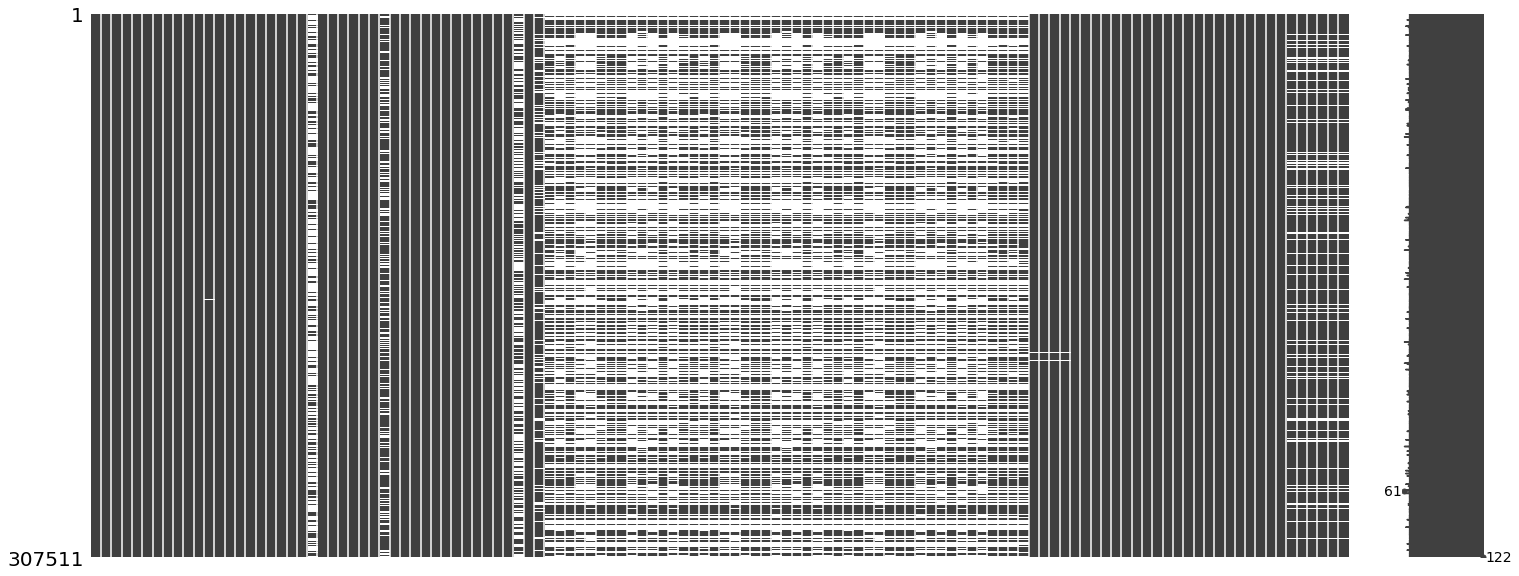

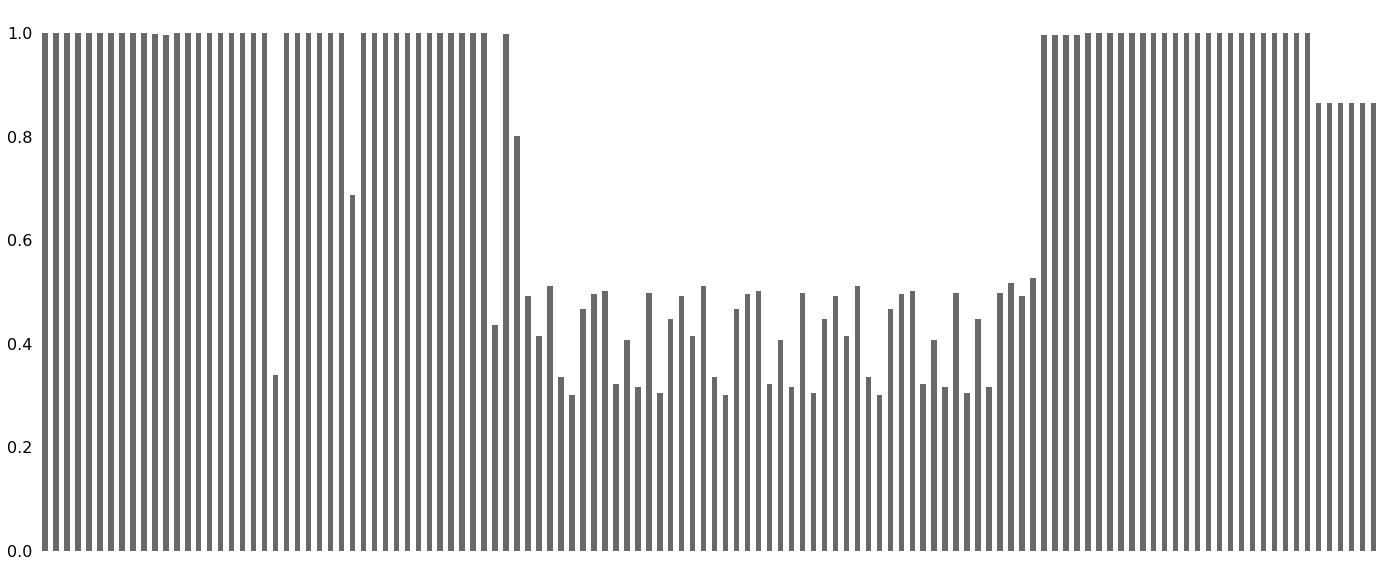

In [3]:
# 欠損値の確認
import missingno as msno
msno.matrix(train)
plt.show()
msno.bar(train)
plt.show()

- 約半分の特徴量は、欠損率が0.5を超えている

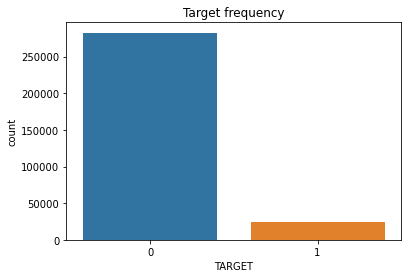

frequency :
0    282686
1     24825
Name: TARGET, dtype: int64


In [4]:
# クラスごとのデータ数を描画
plt.title('Target frequency')
sns.countplot(x='TARGET', data=train)
plt.show()

print('frequency :\n{}'.format(train['TARGET'].value_counts()))

- 9割以上が返済の遅延なし（0）

< numerical variables >


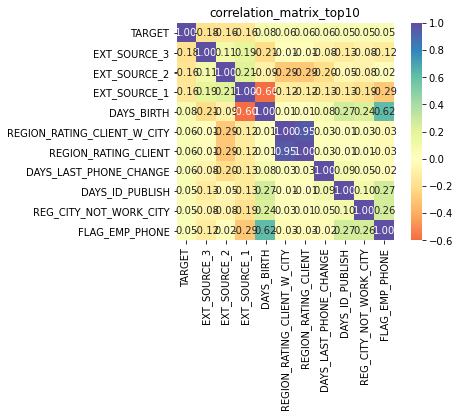

In [5]:
# 相関係数が計算可能な上位10個を取り出す
train_corr = train.corr()
corr_top10 = train_corr['TARGET'].abs().sort_values(ascending=False).index[:11]
sns.heatmap(train[corr_top10].corr(), cbar=True, annot=True,
            square=True, cmap='Spectral', center=0, fmt='.2f')
print('< numerical variables >')
plt.title("correlation_matrix_top10")
plt.show()

In [6]:
# この中から上位3つ（EXT_SOURCE_1～3）を学習に用いる
df_train = train.loc[:,['TARGET', 'SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
display(df_train.head())
display(df_train.describe())
print('< deficits >')
display(df_train.isnull().sum())

,TARGET,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,0.083037,0.262949,0.139376
1,0,100003,0.311267,0.622246,NaN
2,0,100004,NaN,0.555912,0.729567
3,0,100006,NaN,0.650442,NaN
4,0,100007,NaN,0.322738,NaN


,TARGET,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000
mean,0.080729,278180.518577,0.502130,5.143927e-01,0.510853
std,0.272419,102790.175348,0.211062,1.910602e-01,0.194844
min,0.000000,100002.000000,0.014568,8.173617e-08,0.000527
25%,0.000000,189145.500000,0.334007,3.924574e-01,0.370650
50%,0.000000,278202.000000,0.505998,5.659614e-01,0.535276
75%,0.000000,367142.500000,0.675053,6.636171e-01,0.669057
max,1.000000,456255.000000,0.962693,8.549997e-01,0.896010


< deficits >


TARGET               0
SK_ID_CURR           0
EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64

- EXT_SOUCEは外部審査機関のスコアで、0～1に正規化されているようだ
- 特にEXT_SOUCE_1の欠損が多い

### 2. 前処理

In [7]:
# 標準化の際に問題となるため、欠損値のあるサンプルを削除
df_train = df_train.dropna()

# 学習データと検証データに分割（3:1）
from sklearn.model_selection import train_test_split
X = df_train.iloc[:, 1:].values
y = df_train['TARGET'].values

# 乱数シード固定、層化を有効にして分割
X_train, X_cv, y_train, y_cv = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y)
print("X_train : {}".format(np.shape(X_train)))
print("y_train : {}".format(np.shape(y_train)))
print("X_cv : {}".format(np.shape(X_cv)))
print("y_cv : {}".format(np.shape(y_cv)))

# 層化されているか確認
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_cv:', np.bincount(y_cv))

X_train : (82191, 4)
y_train : (82191,)
X_cv : (27398, 4)
y_cv : (27398,)
Labels counts in y: [101591   7998]
Labels counts in y_train: [76193  5998]
Labels counts in y_cv: [25398  2000]


In [8]:
# IDを除く
ID_train = X_train[:, 0]
ID_cv = X_cv[:, 0]
print('ID_train :{}'.format(ID_train[:3]))
print('ID_cv :{}\n\n'.format(ID_cv[:3]))
X_train = X_train[:, 1:]
X_cv = X_cv[:, 1:]

# 標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_cv_std = sc.transform(X_cv)

print('X_train_std : \n{}'.format(X_train_std[:3]))
print(np.shape(X_train_std))
print('\nX_cv_std : \n{}'.format(X_cv_std[:3]))
print(np.shape(X_cv_std))

ID_train :[198906. 132798. 124856.]
ID_cv :[117312. 330629. 248365.]


X_train_std : 
[[ 0.22651379 -0.13758677  0.35771772]
 [ 0.00286757 -0.7989995   1.30858906]
 [ 1.66496606 -0.65510331  0.0441695 ]]
(82191, 3)

X_cv_std : 
[[ 0.70153405  0.56330255  0.80693281]
 [ 0.48926416  0.42622462  1.3224442 ]
 [-0.27625814 -0.41764957 -0.14120959]]
(27398, 3)


### 3. 学習

In [9]:
# ロジスティック回帰で学習
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_std, y_train)

# 学習モデルから訓練/検証データの確率を出力
probs_train = lr.predict_proba(X_train_std)
probs_cv = lr.predict_proba(X_cv_std)
print("probability (train) : \n{}".format(probs_train[:3]))
print(np.shape(probs_train))
print("\nprobability (cv) : \n{}".format(probs_cv[:3]))
print(np.shape(probs_cv))

probability (train) : 
[[0.95858018 0.04141982]
 [0.96526112 0.03473888]
 [0.96820973 0.03179027]]
(82191, 2)

probability (cv) : 
[[0.97924624 0.02075376]
 [0.98190232 0.01809768]
 [0.92711121 0.07288879]]
(27398, 2)


### 4. 評価・検証

In [10]:
# AUC算出
from sklearn.metrics import roc_auc_score

AUC_train = roc_auc_score(y_train, probs_train[:, 1])
AUC_cv = roc_auc_score(y_cv, probs_cv[:, 1])
print("AUC (train) : {:.3f}".format(AUC_train))
print("\nAUC (cv) : {:.3f}".format(AUC_cv))

AUC (train) : 0.745

AUC (cv) : 0.735


- まずまずの予測はできている様子
- 訓練 / 検証データ間でAUCに大差はなく、過学習の程度は小さそう

### 【問題3】テストデータに対する推定  
テストデータ（``application_test.csv``）に対して推定を行い、Kaggleに提出を行ってください。
正しく提出が行えていれば、精度は低くても構いません。

In [11]:
# テストデータの読み込み
test = pd.read_csv('application_test.csv')
df_test = test.loc[:,['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
display(df_test.head())
display(df_test.info())
display(df_test.describe())
display(df_test.isnull().sum())

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100001,0.752614,0.789654,0.159520
1,100005,0.564990,0.291656,0.432962
2,100013,NaN,0.699787,0.610991
3,100028,0.525734,0.509677,0.612704
4,100038,0.202145,0.425687,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SK_ID_CURR    48744 non-null  int64  
 1   EXT_SOURCE_1  28212 non-null  float64
 2   EXT_SOURCE_2  48736 non-null  float64
 3   EXT_SOURCE_3  40076 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1.5 MB


None

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,48744.000000,28212.000000,48736.000000,40076.000000
mean,277796.676350,0.501180,0.518021,0.500106
std,103169.547296,0.205142,0.181278,0.189498
min,100001.000000,0.013458,0.000008,0.000527
25%,188557.750000,0.343695,0.408066,0.363945
50%,277549.000000,0.506771,0.558758,0.519097
75%,367555.500000,0.665956,0.658497,0.652897
max,456250.000000,0.939145,0.855000,0.882530


SK_ID_CURR          0
EXT_SOURCE_1    20532
EXT_SOURCE_2        8
EXT_SOURCE_3     8668
dtype: int64

- 訓練データと同様、正規化された特徴量
- EXT_SOURCE_1の欠損が多い

In [12]:
# 前処理
# 標準化は訓練データのインスタンスを使用する
# 標準化前に、欠損値はそれぞれの平均値で補填

df_test['EXT_SOURCE_1'] = df_test['EXT_SOURCE_1'].fillna(0.501180)
df_test['EXT_SOURCE_2'] = df_test['EXT_SOURCE_2'].fillna(0.518021)
df_test['EXT_SOURCE_3'] = df_test['EXT_SOURCE_3'].fillna(0.500106)
X_test = df_test.iloc[:, 1:].values
ID_test = df_test['SK_ID_CURR'].values
print('ID_test :{}\n'.format(ID_test[:3]))

X_test_std = sc.transform(X_test)
print('X_test_std : \n{}'.format(X_test_std[:3]))
print(np.shape(X_test_std))

ID_test :[100001 100005 100013]

X_test_std : 
[[ 1.16486189  1.43180338 -1.73214416]
 [ 0.27134634 -1.30335542 -0.32492293]
 [-0.0325344   0.93822401  0.59127503]]
(48744, 3)


In [13]:
# 学習・推論
probs_test = lr.predict_proba(X_test_std)
print("probability (test) : \n{}".format(probs_test[:3]))
print(np.shape(probs_test))

probability (test) : 
[[0.95163683 0.04836317]
 [0.91382449 0.08617551]
 [0.97201733 0.02798267]]
(48744, 2)


In [14]:
# 提出データの出力
submit_df = pd.DataFrame([ID_test, probs_test[:, 1]], index=['SK_ID_CURR','TARGET']).T
submit_df['SK_ID_CURR'] = submit_df['SK_ID_CURR'].astype(int)
display(submit_df.head())
submit_df.to_csv('submission_csv', index=False, header=True)

,SK_ID_CURR,TARGET
0,100001,0.048363
1,100005,0.086176
2,100013,0.027983
3,100028,0.038284
4,100038,0.113446


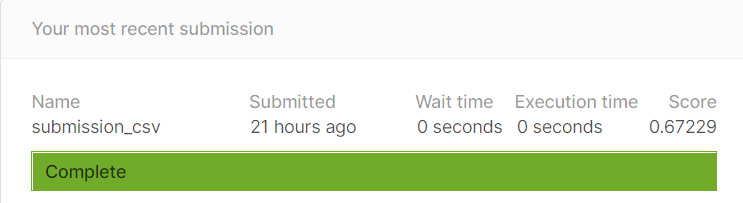

In [15]:
# Kaggleに提出
from IPython.display import Image
Image("4-1.png")

- 検証データと比較し、AUC scoreは低下している
- バイアスが大きく、精度を上げるにはモデルを複雑化する必要がありそうか

### 【問題4】特徴量エンジニアリング  
精度を上げるために以下のような観点で **特徴量エンジニアリング（Feature Engineering）** を行ってください。
- どの特徴量を使うか
- どう前処理をするか  

何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。
精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

### ＜特徴量＞  
1. 特徴量を増やしてみる
2. 自分で新たに特徴量を作り、追加してみる

#### 1. 特徴量の追加

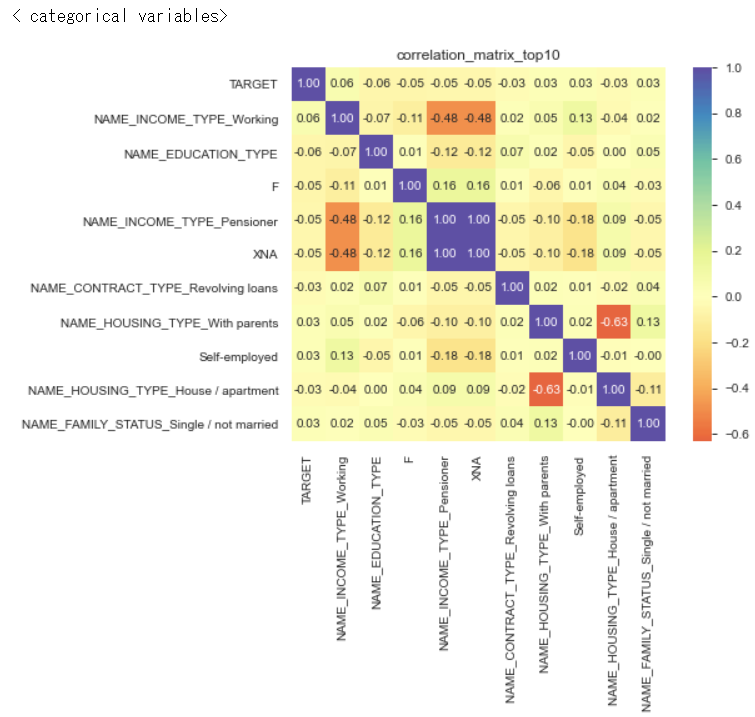

In [16]:
# カテゴリカル変数を数値変換し、相関係数を算出
# week3授業課題で作成したもの
Image("4-2.png")

- これら相関係数上位のカテゴリカル変数から、1.収入形態、2.教育水準、3.性別、4.契約種別の4つを追加する
- 数値変数には、相関係数上位のものから1.年齢、2.HomeCreditによるレーティング、3.最後に電話を変えてから何日経ったか を追加する

In [17]:
# 特徴量の選択
df_1 = train.loc[:,['TARGET', 
                    'SK_ID_CURR', 
                    'EXT_SOURCE_1', 
                    'EXT_SOURCE_2', 
                    'EXT_SOURCE_3', 
                    'DAYS_BIRTH',
                    'REGION_RATING_CLIENT',
                    'DAYS_LAST_PHONE_CHANGE',
                    'NAME_INCOME_TYPE',
                    'NAME_EDUCATION_TYPE',
                    'CODE_GENDER',
                    'NAME_CONTRACT_TYPE']]
display(df_1.head())
display(df_1.describe())
display(df_1.isnull().sum())

,TARGET,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE
0,1,100002,0.083037,0.262949,0.139376,-9461,2,-1134.0,Working,Secondary / secondary special,M,Cash loans
1,0,100003,0.311267,0.622246,NaN,-16765,1,-828.0,State servant,Higher education,F,Cash loans
2,0,100004,NaN,0.555912,0.729567,-19046,2,-815.0,Working,Secondary / secondary special,M,Revolving loans
3,0,100006,NaN,0.650442,NaN,-19005,2,-617.0,Working,Secondary / secondary special,F,Cash loans
4,0,100007,NaN,0.322738,NaN,-19932,2,-1106.0,Working,Secondary / secondary special,M,Cash loans


,TARGET,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE
count,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,307511.000000,307511.000000,307510.000000
mean,0.080729,278180.518577,0.502130,5.143927e-01,0.510853,-16036.995067,2.052463,-962.858788
std,0.272419,102790.175348,0.211062,1.910602e-01,0.194844,4363.988632,0.509034,826.808487
min,0.000000,100002.000000,0.014568,8.173617e-08,0.000527,-25229.000000,1.000000,-4292.000000
25%,0.000000,189145.500000,0.334007,3.924574e-01,0.370650,-19682.000000,2.000000,-1570.000000
50%,0.000000,278202.000000,0.505998,5.659614e-01,0.535276,-15750.000000,2.000000,-757.000000
75%,0.000000,367142.500000,0.675053,6.636171e-01,0.669057,-12413.000000,2.000000,-274.000000
max,1.000000,456255.000000,0.962693,8.549997e-01,0.896010,-7489.000000,3.000000,0.000000


TARGET                         0
SK_ID_CURR                     0
EXT_SOURCE_1              173378
EXT_SOURCE_2                 660
EXT_SOURCE_3               60965
DAYS_BIRTH                     0
REGION_RATING_CLIENT           0
DAYS_LAST_PHONE_CHANGE         1
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
CODE_GENDER                    0
NAME_CONTRACT_TYPE             0
dtype: int64

- 数値変数では、特徴量によってスケールが異なる
- EXT_SOURCE以外にはDAYS_LAST_PHONE_CHANGEに1つだけ欠損あり

In [18]:
# 収入形態の数値化
df_1['NAME_INCOME_TYPE'] = pd.get_dummies(df_1['NAME_INCOME_TYPE'], drop_first=True)
df_1['NAME_INCOME_TYPE'].head()

0    0
1    0
2    0
3    0
4    0
Name: NAME_INCOME_TYPE, dtype: uint8

In [19]:
# 教育水準の数値化（順序尺度）
education_map = {'Lower secondary': 1, 
                 'Secondary / secondary special': 2,
                 'Incomplete higher': 3,
                 'Higher education': 4,
                 'Academic degree':5}
df_1['NAME_EDUCATION_TYPE'] = df_1['NAME_EDUCATION_TYPE'].map(education_map)
df_1['NAME_EDUCATION_TYPE'].head()

0    2
1    4
2    2
3    2
4    2
Name: NAME_EDUCATION_TYPE, dtype: int64

In [20]:
# 性別データの数値化
df_temp = pd.get_dummies(df_1['CODE_GENDER'])
df_1['CODE_GENDER'] = df_temp[['F']]
df_1['CODE_GENDER'].head()

0    0
1    1
2    0
3    1
4    0
Name: CODE_GENDER, dtype: uint8

In [21]:
# 契約種別の数値化
df_1['NAME_CONTRACT_TYPE'] = pd.get_dummies(df_1['NAME_CONTRACT_TYPE'], drop_first=True)
df_1['NAME_CONTRACT_TYPE'].head()

0    0
1    0
2    1
3    0
4    0
Name: NAME_CONTRACT_TYPE, dtype: uint8

In [22]:
# データの確認
display(df_1.head())
display(df_1.describe())

,TARGET,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE
0,1,100002,0.083037,0.262949,0.139376,-9461,2,-1134.0,0,2,0,0
1,0,100003,0.311267,0.622246,NaN,-16765,1,-828.0,0,4,1,0
2,0,100004,NaN,0.555912,0.729567,-19046,2,-815.0,0,2,0,1
3,0,100006,NaN,0.650442,NaN,-19005,2,-617.0,0,2,1,0
4,0,100007,NaN,0.322738,NaN,-19932,2,-1106.0,0,2,0,0


,TARGET,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE
count,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,307511.000000,307511.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.080729,278180.518577,0.502130,5.143927e-01,0.510853,-16036.995067,2.052463,-962.858788,0.232892,2.509507,0.658344,0.095213
std,0.272419,102790.175348,0.211062,1.910602e-01,0.194844,4363.988632,0.509034,826.808487,0.422675,0.874544,0.474266,0.293509
min,0.000000,100002.000000,0.014568,8.173617e-08,0.000527,-25229.000000,1.000000,-4292.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,189145.500000,0.334007,3.924574e-01,0.370650,-19682.000000,2.000000,-1570.000000,0.000000,2.000000,0.000000,0.000000
50%,0.000000,278202.000000,0.505998,5.659614e-01,0.535276,-15750.000000,2.000000,-757.000000,0.000000,2.000000,1.000000,0.000000
75%,0.000000,367142.500000,0.675053,6.636171e-01,0.669057,-12413.000000,2.000000,-274.000000,0.000000,3.000000,1.000000,0.000000
max,1.000000,456255.000000,0.962693,8.549997e-01,0.896010,-7489.000000,3.000000,0.000000,1.000000,5.000000,1.000000,1.000000


- すべて数値データとなった
- これらを特徴量追加分のデータとして使用する（``df_1``）  

#### 2. 特徴量の作成
- スケールの等しい特徴量をまとめる  
…正規化された'EXT_SOURCE'の1～3や二値分類（0/1）の'FALG' / 'REG'シリーズなど、同じスケールをもつ特徴量同士を足して統合してみる。「携帯電話につながったかどうか」や「申告していた住所と実際の住所が違ったか」などを統合するので、信用にとり＋の情報は加点、－の情報は減点する。  
  
- 職業別でのdefault率を、そのまま特徴量として用いる  
…職業間でdefault率に差があったため、これをそのまま数値データに変換する

In [23]:
# 'EXT_SOURCE'の1～3を足して新たなスコアにする
df_temp = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
display(df_temp.head())
df_ext = df_temp.sum(axis=1)
df_ext.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,0.083037,0.262949,0.139376
1,0.311267,0.622246,NaN
2,NaN,0.555912,0.729567
3,NaN,0.650442,NaN
4,NaN,0.322738,NaN


0    0.485361
1    0.933513
2    1.285479
3    0.650442
4    0.322738
dtype: float64

In [24]:
# 信用に＋の数値特徴を足し、－の特徴を引く
# 電話・メール関係（1:加点、0：減点）
df_temp = train.iloc[:, 22:28]
display(df_temp.head())
df_pos = df_temp.sum(axis=1)
display(df_pos.head())

# 住所関係（1:減点、0:加点）
df_temp = train.iloc[:, 34:40]
display(df_temp.head())
df_neg = df_temp.sum(axis=1)
display(df_neg.head())

df_credit = df_pos - df_neg
df_credit.head()

,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL
0,1,1,0,1,1,0
1,1,1,0,1,1,0
2,1,1,1,1,1,0
3,1,1,0,1,0,0
4,1,1,0,1,0,0


0    4
1    4
2    5
3    3
4    3
dtype: int64

,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,1,1


0    0
1    0
2    0
3    0
4    2
dtype: int64

0    4
1    4
2    5
3    3
4    1
dtype: int64

In [25]:
# 欠損値の多い住居関係の特徴量群もスケールが同じであるため統合
df_temp = train.iloc[:, 44:90]
display(df_temp.head())
df_house = df_temp.sum(axis=1)
df_house.head()

,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE
0,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,...,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick"
1,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,...,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0    6.1040
1    8.7279
2    0.0000
3    0.0000
4    0.0000
dtype: float64

In [26]:
# default関係の情報も統合
df_temp = train.iloc[:, 91:95]
display(df_temp.head())
df_default = df_temp.sum(axis=1)
df_default.head()

,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,2.0,2.0,2.0,2.0
1,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0
3,2.0,0.0,2.0,0.0
4,0.0,0.0,0.0,0.0


0    8.0
1    2.0
2    0.0
3    4.0
4    0.0
dtype: float64

In [27]:
# document関係の情報も統合
df_temp = train.iloc[:, 96:116]
display(df_temp.head())
df_document = df_temp.sum(axis=1)
df_document.head()

,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


0    1
1    1
2    0
3    1
4    1
dtype: int64

In [28]:
# Inquire(信用調査機関への問い合わせ回数)も統合
df_temp = train.iloc[:, 117:123]
display(df_temp.head())
df_inquire = df_temp.sum(axis=1)
df_inquire.head()

,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0


0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

In [29]:
# 職業ごとのdefault率を算出
df_job = pd.get_dummies(train['OCCUPATION_TYPE'])
display(df_job.head())
df_temp = pd.concat([train['TARGET'], df_job], axis=1)
df_def = df_temp[df_temp['TARGET']==1]
df_def = df_def.drop(['TARGET'], axis=1)

print("\n< total >")
display(df_job.sum())
print("\n< default >")
display(df_def.sum())
print("\n< rate(default/total) >")
display(df_job.sum() / df_def.sum())

,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0



< total >


Accountants               9813
Cleaning staff            4653
Cooking staff             5946
Core staff               27570
Drivers                  18603
HR staff                   563
High skill tech staff    11380
IT staff                   526
Laborers                 55186
Low-skill Laborers        2093
Managers                 21371
Medicine staff            8537
Private service staff     2652
Realty agents              751
Sales staff              32102
Secretaries               1305
Security staff            6721
Waiters/barmen staff      1348
dtype: int64


< default >


Accountants               474
Cleaning staff            447
Cooking staff             621
Core staff               1738
Drivers                  2107
HR staff                   36
High skill tech staff     701
IT staff                   34
Laborers                 5838
Low-skill Laborers        359
Managers                 1328
Medicine staff            572
Private service staff     175
Realty agents              59
Sales staff              3092
Secretaries                92
Security staff            722
Waiters/barmen staff      152
dtype: int64


< rate(default/total) >


Accountants              20.702532
Cleaning staff           10.409396
Cooking staff             9.574879
Core staff               15.863061
Drivers                   8.829141
HR staff                 15.638889
High skill tech staff    16.233951
IT staff                 15.470588
Laborers                  9.452895
Low-skill Laborers        5.830084
Managers                 16.092620
Medicine staff           14.924825
Private service staff    15.154286
Realty agents            12.728814
Sales staff              10.382277
Secretaries              14.184783
Security staff            9.308864
Waiters/barmen staff      8.868421
dtype: float64

In [30]:
# この数値データをそのまま特徴量として用いる
def_rate_map = {'Accountants':              20.702532,
                'Cleaning staff':           10.409396,
                'Cooking staff':             9.574879,
                'Core staff':               15.863061,
                'Drivers':                   8.829141,
                'HR staff':                 15.638889,
                'High skill tech staff':    16.233951,
                'IT staff':                 15.470588,
                'Laborers':                  9.452895,
                'Low-skill Laborers':        5.830084,
                'Managers':                 16.092620,
                'Medicine staff':           14.924825,
                'Private service staff':    15.154286,
                'Realty agents':            12.728814,
                'Sales staff':              10.382277,
                'Secretaries':              14.184783,
                'Security staff':            9.308864,
                'Waiters/barmen staff':      8.868421}
df_occupation = train['OCCUPATION_TYPE'].map(def_rate_map)
df_occupation

0          9.452895
1         15.863061
2          9.452895
3          9.452895
4         15.863061
            ...    
307506    10.382277
307507          NaN
307508    16.092620
307509     9.452895
307510     9.452895
Name: OCCUPATION_TYPE, Length: 307511, dtype: float64

In [31]:
df_2 = pd.DataFrame({'TARGET': train['TARGET'],
                     'Ext' : df_ext,
                     'Credit' : df_credit,
                     'House' : df_house,
                     'Default' : df_default,
                     'Document' : df_document,
                     'Inquire' : df_inquire,
                     'Occupation' : df_occupation})

# データの確認
display(df_2.head())
display(df_2.describe())

,TARGET,Ext,Credit,House,Default,Document,Inquire,Occupation
0,1,0.485361,4,6.1040,8.0,1,1.0,9.452895
1,0,0.933513,4,8.7279,2.0,1,0.0,15.863061
2,0,1.285479,5,0.0000,0.0,0,0.0,9.452895
3,0,0.650442,3,0.0000,4.0,1,0.0,9.452895
4,0,0.322738,1,0.0000,0.0,1,0.0,15.863061


,TARGET,Ext,Credit,House,Default,Document,Inquire,Occupation
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,211120.000000
mean,0.080729,1.141887,2.760422,3.909895,3.060811,0.930155,2.140148,12.282438
std,0.272419,0.468011,1.280419,4.434600,5.068223,0.344295,2.288234,3.534176
min,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,5.830084
25%,0.000000,0.799308,2.000000,0.000000,0.000000,1.000000,0.000000,9.452895
50%,0.000000,1.142541,3.000000,3.135400,0.000000,1.000000,2.000000,10.382277
75%,0.000000,1.438440,3.000000,7.534300,4.000000,1.000000,3.000000,15.863061
max,1.000000,2.560251,6.000000,37.790400,750.000000,4.000000,262.000000,20.702532


- すべて数値データの特徴量
- これらを特徴量創作分のデータとして用いる（``df_2``）

### ＜前処理＞  
1. 標準化の有無で比較
2. 欠損値の有無で比較  
(すべて``df_1``で検証する)

In [32]:
# 欠損値
# ①平均値で補填
df_f = df_1.copy()
df_f['EXT_SOURCE_1'] = df_f['EXT_SOURCE_1'].fillna(0.502130)
df_f['EXT_SOURCE_2'] = df_f['EXT_SOURCE_2'].fillna(0.514393)
df_f['EXT_SOURCE_3'] = df_f['EXT_SOURCE_3'].fillna(0.510853)
df_f['DAYS_LAST_PHONE_CHANGE'] = df_f['DAYS_LAST_PHONE_CHANGE'].fillna(-962.858788)

# ②欠損のあるサンプルを削除
df_d = df_1.dropna()

print("< fill NaN >")
print(np.shape(df_f))
print("\n< drop NaN >")
print(np.shape(df_d))

< fill NaN >
(307511, 12)

< drop NaN >
(109589, 12)


In [33]:
# 訓練 / 検証データに分割（欠損値補填）
X = df_f.iloc[:, 1:].values
y = df_f['TARGET'].values
Xf_train, Xf_cv, yf_train, yf_cv = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y)
IDf_train = Xf_train[:, 0]
IDf_cv = Xf_cv[:, 0]
Xf_train = Xf_train[:, 1:]
Xf_cv = Xf_cv[:, 1:]

In [34]:
# 訓練 / 検証データに分割（欠損値削除）
X = df_d.iloc[:, 1:].values
y = df_d['TARGET'].values
Xd_train, Xd_cv, yd_train, yd_cv = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y)
IDd_train = Xd_train[:, 0]
IDd_cv = Xd_cv[:, 0]
Xd_train = Xd_train[:, 1:]
Xd_cv = Xd_cv[:, 1:]

In [35]:
# 標準化インスタンスは欠損値を削除したデータで作成
sc_1 = StandardScaler()
sc_1.fit(Xd_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

### ＜学習・検証＞  
以下の条件で学習・検証を行う。  
1. 特徴量：追加、欠損値：補填、標準化：なし  
2. 特徴量：追加、欠損値：削除、標準化：なし  
3. 特徴量：追加、欠損値：補填、標準化：あり  
4. 特徴量：追加、欠損値：削除、標準化：あり  
5. 特徴量：創作、欠損値：削除、標準化：あり  

In [36]:
# 学習・推論①
lr_1 = LogisticRegression()
lr_1.fit(Xf_train, yf_train)
probs_1 = lr_1.predict_proba(Xf_cv)

# 学習・推論②
lr_2 = LogisticRegression()
lr_2.fit(Xd_train, yd_train)
probs_2 = lr_2.predict_proba(Xd_cv)

# 学習・推論③
Xf_train_std = sc_1.transform(Xf_train)
Xf_cv_std = sc_1.transform(Xf_cv)
lr_3 = LogisticRegression()
lr_3.fit(Xf_train_std, yf_train)
probs_3 = lr_3.predict_proba(Xf_cv_std)

# 学習・推論④
Xd_train_std = sc_1.transform(Xd_train)
Xd_cv_std = sc_1.transform(Xd_cv)
lr_4 = LogisticRegression()
lr_4.fit(Xd_train_std, yd_train)
probs_4 = lr_4.predict_proba(Xd_cv_std)

In [37]:
# 評価
print("=== additional features ===\n")

AUC_1 = roc_auc_score(yf_cv, probs_1[:, 1])
print('< fill NaN / Standardization(-) >')
print('AUC(cv) = {:.3f}'.format(AUC_1))

AUC_2 = roc_auc_score(yd_cv, probs_2[:, 1])
print('\n< drop NaN / Standardization(-) >')
print('AUC(cv) = {:.3f}'.format(AUC_2))

AUC_3 = roc_auc_score(yf_cv, probs_3[:, 1])
print('\n< fill NaN / Standardization(+) >')
print('AUC(cv) = {:.3f}'.format(AUC_3))

AUC_4 = roc_auc_score(yd_cv, probs_4[:, 1])
print('\n< drop NaN / Standardization(+) >')
print('AUC(cv) = {:.3f}'.format(AUC_4))

=== additional features ===

< fill NaN / Standardization(-) >
AUC(cv) = 0.634

< drop NaN / Standardization(-) >
AUC(cv) = 0.629

< fill NaN / Standardization(+) >
AUC(cv) = 0.733

< drop NaN / Standardization(+) >
AUC(cv) = 0.747


### ＜考察①＞  
上記のAUCは、学習とは別に用意した検証データから計算した値である。今回の結果では標準化したデータで学習がうまく進んでおり、選択する学習の手法にもよるだろうが、尺度の異なる特徴量を組み合わせる際に寄与を等しくすることの重要さが伺えた。対して、欠損値の補填 / 削除では標準化の有無ほど学習に差は出ておらず、標準化した場合には欠損値を削除した方が僅かに精度が上がっていた。これは、標準化計算のためのデータと欠損値を補填したデータとが異なるため、分布にわずかな歪みが出てしまった可能性が考慮された。

- 上記の結果を踏まえ、欠損値は削除し標準化を行う形で、自分なりに作成した特徴量で学習をしてみる。

In [38]:
# 欠損値削除
df_2 = df_2.dropna()

# 訓練 / 検証データに分割
X = df_2.iloc[:, 1:].values
y = df_2['TARGET'].values
X_train, X_cv, y_train, y_cv = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y)
ID_train = X_train[:, 0]
ID_cv = X_cv[:, 0]
X_train = X_train[:, 1:]
X_cv = X_cv[:, 1:]

# 標準化
sc_2 = StandardScaler()
sc_2.fit(X_train)
X_train_std = sc_2.transform(X_train)
X_cv_std = sc_2.transform(X_cv)

# 学習・推論
lr_5 = LogisticRegression()
lr_5.fit(X_train_std, y_train)
probs_5 = lr_5.predict_proba(X_cv_std)

# 評価
AUC_5 = roc_auc_score(y_cv, probs_5[:, 1])
print('=== original features ===\n')
print('< drop NaN / Standardization(+) >')
print('AUC(cv) = {:.3f}'.format(AUC_5))

=== original features ===

< drop NaN / Standardization(+) >
AUC(cv) = 0.599


### ＜考察②＞  
今回作成した特徴量では、特徴量'EXT_SOURCE'の1～3のみを用いた予測よりも精度が低下していた。作成した特徴量はこれらを含んでいたが、その他の予測に寄与しない特徴量が追加されたことで全体の精度が低下してしまったものと推察された。

### ＜提出＞  
特徴量を追加したものでは'EXT_SOURCE'の1～3のみよりもAUCが増加していたため、これをkaggleに提出してみる

In [39]:
df_test = test.loc[:,['SK_ID_CURR', 
                      'EXT_SOURCE_1', 
                      'EXT_SOURCE_2', 
                      'EXT_SOURCE_3',
                      'DAYS_BIRTH',
                      'REGION_RATING_CLIENT',
                      'DAYS_LAST_PHONE_CHANGE',
                      'NAME_INCOME_TYPE',
                      'NAME_EDUCATION_TYPE',
                      'CODE_GENDER',
                      'NAME_CONTRACT_TYPE']]

df_test['NAME_INCOME_TYPE'] = pd.get_dummies(df_test['NAME_INCOME_TYPE'], drop_first=True)

education_map = {'Lower secondary': 1, 
                 'Secondary / secondary special': 2,
                 'Incomplete higher': 3,
                 'Higher education': 4,
                 'Academic degree':5}
df_test['NAME_EDUCATION_TYPE'] = df_test['NAME_EDUCATION_TYPE'].map(education_map)
df_test['NAME_EDUCATION_TYPE'].head()

df_temp = pd.get_dummies(df_test['CODE_GENDER'])
df_test['CODE_GENDER'] = df_temp[['F']]

df_test['NAME_CONTRACT_TYPE'] = pd.get_dummies(df_test['NAME_CONTRACT_TYPE'], drop_first=True)

display(df_test.head())
display(np.shape(df_test))
display(df_test.isnull().sum())

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE
0,100001,0.752614,0.789654,0.159520,-19241,2,-1740.0,0,4,1,0
1,100005,0.564990,0.291656,0.432962,-18064,2,0.0,0,2,0,0
2,100013,NaN,0.699787,0.610991,-20038,2,-856.0,0,4,0,0
3,100028,0.525734,0.509677,0.612704,-13976,2,-1805.0,0,2,1,0
4,100038,0.202145,0.425687,NaN,-13040,2,-821.0,0,2,0,0


(48744, 11)

SK_ID_CURR                    0
EXT_SOURCE_1              20532
EXT_SOURCE_2                  8
EXT_SOURCE_3               8668
DAYS_BIRTH                    0
REGION_RATING_CLIENT          0
DAYS_LAST_PHONE_CHANGE        0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
CODE_GENDER                   0
NAME_CONTRACT_TYPE            0
dtype: int64

In [40]:
# サンプル数が変わると提出できないため、欠損値は平均値で補填
# 補填後、学習④で用いた標準化インスタンスで標準化
df_test['EXT_SOURCE_1'] = df_test['EXT_SOURCE_1'].fillna(0.501180)
df_test['EXT_SOURCE_2'] = df_test['EXT_SOURCE_2'].fillna(0.518021)
df_test['EXT_SOURCE_3'] = df_test['EXT_SOURCE_3'].fillna(0.500106)
df_test['DAYS_LAST_PHONE_CHANGE'] = df_test['DAYS_LAST_PHONE_CHANGE'].fillna(-1077.766228)
display(df_test.isnull().sum())

X_test = df_test.iloc[:, 1:].values
ID_test = df_test['SK_ID_CURR'].values
X_test_std = sc_1.transform(X_test)
print('X_test_std : \n{}'.format(X_test_std[0]))
print(np.shape(X_test_std))

SK_ID_CURR                0
EXT_SOURCE_1              0
EXT_SOURCE_2              0
EXT_SOURCE_3              0
DAYS_BIRTH                0
REGION_RATING_CLIENT      0
DAYS_LAST_PHONE_CHANGE    0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
CODE_GENDER               0
NAME_CONTRACT_TYPE        0
dtype: int64

X_test_std : 
[ 1.16486189  1.43180338 -1.73214416 -1.13274704 -0.11480667 -0.81597829
 -0.5986791   1.43012931  0.67854285 -0.3339616 ]
(48744, 10)


In [41]:
# 学習④モデルで推論
probs_test = lr_4.predict_proba(X_test_std)

# 提出データの出力
submit_df = pd.DataFrame([ID_test, probs_test[:, 1]], index=['SK_ID_CURR','TARGET']).T
submit_df['SK_ID_CURR'] = submit_df['SK_ID_CURR'].astype(int)
display(submit_df.head())
submit_df.to_csv('submission2_csv', index=False, header=True)

,SK_ID_CURR,TARGET
0,100001,0.047637
1,100005,0.108016
2,100013,0.031144
3,100028,0.038418
4,100038,0.128997


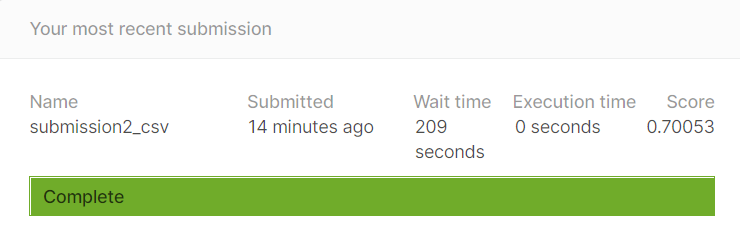

In [42]:
# Kaggleに提出
Image("4-3.png")

- 特徴量追加前（0.67229）と比較して精度が向上している
- 特徴量の追加により、バイアスが低下したものと思われる

### ＜考察のまとめ＞  
特徴量の前処理については、標準化の重要性を再確認した。またデータ数が十分であれば、欠損値は削除して学習モデルを構築したほうがよい印象であった。  
特徴量の作成については、相関のなさそうな特徴量を単に統合するだけでは、有用な特徴量へ変えることは難しいことを学んだ。  
今後は自分で仮説を立てて検証を行い、有用な特徴量を発見していけるようにしたい。